In [1]:
import os
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib
from tqdm import tqdm
from itertools import combinations
from napatrackmater.Trackvector import (
    BROWNIAN_FEATURES
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
2024-12-08 23:25:19.385127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-08 23:25:19.756910: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 23:25:20.784443: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.s

In [2]:
dataset_name = 'Second'
home_folder = '/home/debian/jz/'
channel = 'nuclei_'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

normalized_dataframe = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}predicted_morpho_feature_attention_shallowest_litest.csv')
print(f'reading data from {normalized_dataframe}')
tracks_dataframe = pd.read_csv(normalized_dataframe)
save_dir = os.path.join(tracking_directory, f'{channel}phasespaces')
Path(save_dir).mkdir(exist_ok=True)
deltat = 10
class_map_gbr = {
        0: "Basal",
        1: "Radial",
        2: "Goblet"
    }

reading data from /home/debian/jz/Mari_Data_Oneat/Mari_Second_Dataset_Analysis/nuclei_membrane_tracking/dataframes/goblet_basal_dataframe_normalized_nuclei_predicted_morpho_feature_attention_shallowest_litest.csv


In [3]:
all_trackmate_ids = [trackid for trackid in tracks_dataframe['TrackMate Track ID'].unique()]
result_dict = {cell_type: {} for cell_type in class_map_gbr.values()}
unique_time_points = tracks_dataframe['t'].unique()

for time_point in unique_time_points:
    time_data = tracks_dataframe[tracks_dataframe['t'] == time_point]

    for cell_type in class_map_gbr.values():
        cell_type_data = time_data[time_data['Cell_Type'] == cell_type]
        
        if not cell_type_data.empty:
            if time_point not in result_dict[cell_type]:
                result_dict[cell_type][time_point] = {}

            for track_id in cell_type_data['Track ID'].unique():
                track_features = cell_type_data[cell_type_data['Track ID'] == track_id][BROWNIAN_FEATURES].to_numpy()

                feature_pairs = list(combinations(BROWNIAN_FEATURES, 2))

                for (feature_name1, feature_name2) in feature_pairs:
                    pair_key = f"{feature_name1}_vs_{feature_name2}"

                    pairwise_values = np.stack(
                        [track_features[:, BROWNIAN_FEATURES.index(feature_name1)],
                         track_features[:, BROWNIAN_FEATURES.index(feature_name2)]],
                        axis=1
                    )

                    if pair_key not in result_dict[cell_type][time_point]:
                        result_dict[cell_type][time_point][pair_key] = []

                    result_dict[cell_type][time_point][pair_key].append({
                        'Track ID': int(track_id),  
                        'Pairwise Values': pairwise_values
                    })


In [4]:
def build_dataframe(result_dict):
    """Converts result_dict to a pandas DataFrame for plotting, including Track ID."""
    rows = []

    for cell_type, time_data in result_dict.items():
        for time_point, feature_dict in time_data.items():
            for feature_pair, track_data in feature_dict.items():
                for track_entry in track_data:
                    track_id = track_entry['Track ID']
                    pairwise_array = track_entry['Pairwise Values']

                    feature_name1, feature_name2 = feature_pair.split('_vs_')
                    for feature1, feature2 in pairwise_array:
                        rows.append({
                            'Cell Type': cell_type,
                            'Time Point': time_point,
                            'Feature Pair': feature_pair,
                            'Track ID': track_id, 
                            feature_name1: feature1,
                            feature_name2: feature2,
                        })

    df = pd.DataFrame(rows)
    return df




def plot_phasespace(df, title='phasespace'):
    """Plots the phase space using seaborn's kdeplot for all time points in one plot per feature pair, with a color bar."""
    
    cmap = plt.cm.viridis
    norm = matplotlib.colors.Normalize(vmin=df['Time Point'].min(), vmax=df['Time Point'].max())

    for cell_type in df['Cell Type'].unique():
        cell_type_df = df[df['Cell Type'] == cell_type]
        
        for feature_pair in cell_type_df['Feature Pair'].unique():
            pair_df = cell_type_df[cell_type_df['Feature Pair'] == feature_pair]
            print(f"Plotting for {cell_type} and feature pair {feature_pair}")
            
            actual_feature_name1, actual_feature_name2 = feature_pair.split('_vs_')

            fig, ax = plt.subplots(figsize=(8, 10))

            for time_point in sorted(pair_df['Time Point'].unique()):
                time_df = pair_df[pair_df['Time Point'] == time_point]
                
                color = cmap(norm(time_point))

                sns.kdeplot(
                    data=time_df,
                    x=actual_feature_name1,
                    y=actual_feature_name2,
                    label=f"Time {time_point}",
                    alpha=0.5,
                    ax=ax,
                    color=color,
                    warn_singular=False
                )

            ax.set_xlabel(f"{actual_feature_name1}", fontsize=14)
            ax.set_ylabel(f"{actual_feature_name2}", fontsize=14)

            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([]) 
            cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
            cbar.set_label('Time Point', fontsize=14)

            ax.set_title(f"{title} - {cell_type}", fontsize=16)
            ax.legend(title="Time Points", loc="upper right", fontsize=10)

            plot_filename = os.path.join(save_dir, f"{title}_{cell_type}_{actual_feature_name1}_{actual_feature_name2}_{dataset_name}_phasespace.png")
            plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()
          

def test_ergodicity(df, feature1='Radius', feature2='Eccentricity_Comp_First', error_tolerance=0.5, time_delta=50, max_failed_tracks=5):
    """
    Tests the ergodicity of the system by comparing time averages and ensemble averages 
    over specified time intervals.
    """
    ergodicity_times = []
    max_diff1_global = -float('inf')
    min_diff1_global = float('inf')
    max_diff2_global = -float('inf')
    min_diff2_global = float('inf')

    for feature_pair in df['Feature Pair'].unique():
        if feature1 not in feature_pair or feature2 not in feature_pair:
            continue
        
        pair_df = df[df['Feature Pair'] == feature_pair]
        actual_feature_name1, actual_feature_name2 = feature_pair.split('_vs_')

        for cell_type in df['Cell Type'].unique():
            
            cell_type_df = pair_df[pair_df['Cell Type'] == cell_type]

            total_time_points = len(cell_type_df['Time Point'].unique())
            time_points = sorted(cell_type_df['Time Point'].unique())

            for start_time in tqdm(range(0, total_time_points + 2 * time_delta, time_delta)):
                if start_time + time_delta >= total_time_points:
                    start_time = total_time_points - time_delta

                end_time = min(start_time + time_delta, total_time_points)
                time_interval_points = time_points[start_time:end_time]

                interval_df = cell_type_df[cell_type_df['Time Point'].isin(time_interval_points)]

                time_averages = {}
                for track_id in interval_df['Track ID'].unique():
                    track_df = interval_df[interval_df['Track ID'] == track_id]
                    time_averages[track_id] = (
                        np.mean(track_df[actual_feature_name1].values/time_delta),
                        np.mean(track_df[actual_feature_name2].values/time_delta)
                    )

                ensemble_averages = {}
                for time_point in time_interval_points:
                    time_df = interval_df[interval_df['Time Point'] == time_point]
                    ensemble_averages[time_point] = (
                        np.mean(time_df[actual_feature_name1].values),
                        np.mean(time_df[actual_feature_name2].values)
                    )

                failed_tracks_count = 0
                for track_id, (time_avg1, time_avg2) in time_averages.items():
                    for time_point in time_interval_points:
                        ensemble_avg1, ensemble_avg2 = ensemble_averages[time_point]
                        diff1 = abs(time_avg1 - ensemble_avg1)
                        diff2 = abs(time_avg2 - ensemble_avg2)

                        max_diff1_global = max(max_diff1_global, diff1)
                        min_diff1_global = min(min_diff1_global, diff1)
                        max_diff2_global = max(max_diff2_global, diff2)
                        min_diff2_global = min(min_diff2_global, diff2)

                        if diff1 > error_tolerance or diff2 > error_tolerance:
                            failed_tracks_count += 1
                            break
                    if failed_tracks_count >= max_failed_tracks:
                        break

                if failed_tracks_count < max_failed_tracks:
                    ergodicity_times.append({
                        'Cell Type': cell_type,
                        'Ergodic Time Interval': f"{start_time}-{end_time}"
                    })
                    
        if ergodicity_times:
            ergodicity_df = pd.DataFrame(ergodicity_times)
            print("Ergodicity Times:\n", ergodicity_df)
        else:
            print(f"Ergodicity was not reached within the specified intervals.")

    # Print global max/min differences
    print(f"Max difference for {feature1}: {max_diff1_global}")
    print(f"Min difference for {feature1}: {min_diff1_global}")
    print(f"Max difference for {feature2}: {max_diff2_global}")
    print(f"Min difference for {feature2}: {min_diff2_global}")




            

In [5]:
feature_dataframe = build_dataframe(result_dict)


In [6]:
test_ergodicity(feature_dataframe,error_tolerance=0.75, feature1='Speed', feature2='Eccentricity_Comp_Third', time_delta=50, max_failed_tracks=5)

100%|██████████| 8/8 [00:05<00:00,  1.59it/s]

Ergodicity Times:
   Cell Type Ergodic Time Interval
0     Basal               200-250
1     Basal               211-261
2     Basal               211-261
3     Basal               211-261
4    Radial               211-261
5    Radial               211-261
6    Radial               211-261
7    Goblet               100-150
8    Goblet               150-200
Max difference for Speed: 1.2469578907328973
Min difference for Speed: 3.318439321530961e-06
Max difference for Eccentricity_Comp_Third: 1.638892417146733
Min difference for Eccentricity_Comp_Third: 1.2761883319034259e-05


Plotting for Basal and feature pair Radius_vs_Eccentricity_Comp_First


/tmp/ipykernel_1416928/4294793287.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Time Points", loc="upper right", fontsize=10)


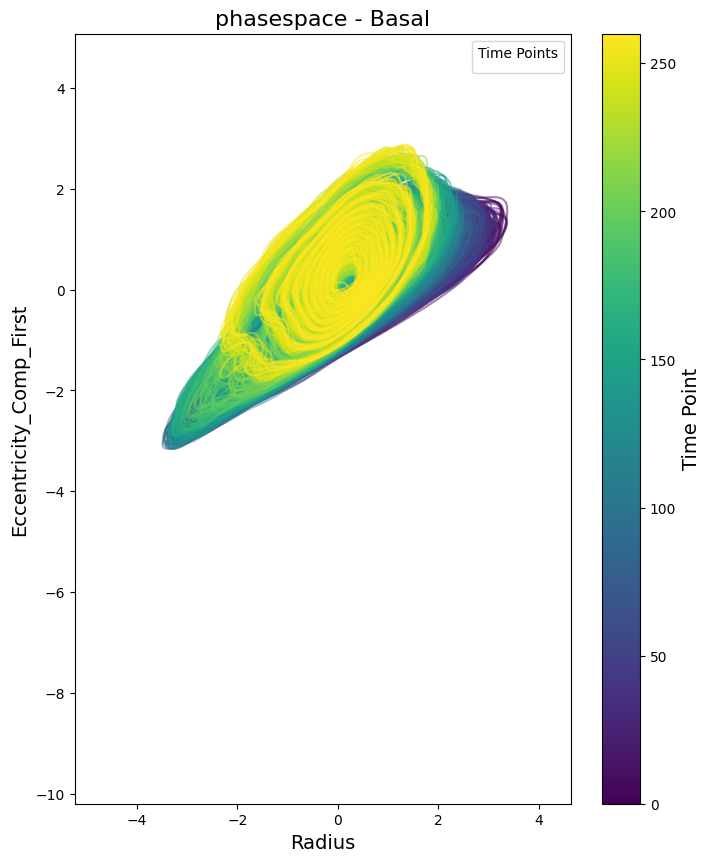

Plotting for Basal and feature pair Radius_vs_Eccentricity_Comp_Second


In [7]:

plot_phasespace(feature_dataframe)